## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

1.13.1


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'
You should consider upgrading via the 'D:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
# %cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

E:\GitHub\1st-DL-CVMarathon\Homework\keras-yolo3


In [3]:
import os
if not os.path.exists("model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

Model exist


In [4]:
# 直接下載 VOC2007 的資料集作為範例
if not os.path.exists("VOCdevkit"):
    os.system("wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar") # 下載 VOC 資料集
    os.system("tar xvf VOCtrainval_06-Nov-2007.tar") # 解壓縮資料集，會花幾分鐘
else:
    print("data exists")

data exists


以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [5]:
if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    sets=[('2007', 'train'), ('2007', 'val')]

    # Pascal VOC 的資料類別
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(year, image_id, list_file):
        in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    wd = "."

    for year, image_set in sets:
        image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
        annotation_path = '%s_%s.txt'%(year, image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        for image_id in image_ids[:100]: # 只處理 100 張圖片來做範例
            list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        list_file.close()

In [6]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [7]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [8]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [12]:
import tensorflow as tf

# 自動增長 GPU 記憶體用量
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
# tf.keras.backend.set_session(sess)
K.set_session(sess)

In [20]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 20 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 90 samples, val on 10 samples, with batch size 16.
Epoch 1/50
5/5 [==============================] - 9s 2s/step - loss: 10923.6268 - val_loss: 8025.3306
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 6767.7831 - val_loss: 4959.2959
Epoch 3/50
5/5 [==============================] - 7s 1s/step - loss: 4064.1238 - val_loss: 2789.7144
Epoch 4/50
5/5 [==============================] - 2s 313ms/step - loss: 2496.1978 - val_loss: 1805.2275
Epoch 5/50
5/5 [==============================] - 2s 316ms/step - loss: 1590.0912 - val_loss: 1257.7351
Epoch 6/50
5/5 [==============================] - 3s 666ms/step - loss: 1078.2105 - val_loss: 856.3817
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 785.6666 - val_loss: 675.1805
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 621.6228 - val_l

In [21]:
from PIL import Image
image = Image.open('dog.jpg') 

In [22]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 3 boxes for img
car 0.32 (482, 82) (672, 161)
car 0.42 (324, 75) (768, 185)
bicycle 0.46 (251, 135) (497, 429)
3.493477200000143


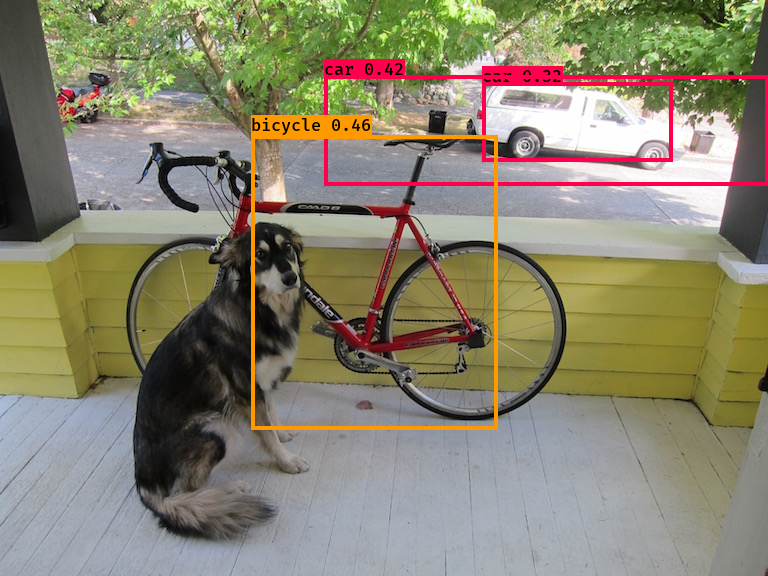

In [23]:
r_image

In [24]:
with open("2007_train.txt", "r") as f:
    d = f.readlines()
d

['./VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6\n',
 './VOCdevkit/VOC2007/JPEGImages/000017.jpg 185,62,279,199,14 90,78,403,336,12\n',
 './VOCdevkit/VOC2007/JPEGImages/000023.jpg 9,230,245,500,1 230,220,334,500,1 2,1,117,369,14 3,2,243,462,14 225,1,334,486,14\n',
 './VOCdevkit/VOC2007/JPEGImages/000026.jpg 90,125,337,212,6\n',
 './VOCdevkit/VOC2007/JPEGImages/000032.jpg 104,78,375,183,0 133,88,197,123,0 195,180,213,229,14 26,189,44,238,14\n',
 './VOCdevkit/VOC2007/JPEGImages/000033.jpg 9,107,499,263,0 421,200,482,226,0 325,188,411,223,0\n',
 './VOCdevkit/VOC2007/JPEGImages/000034.jpg 116,167,360,400,18 141,153,333,229,18\n',
 './VOCdevkit/VOC2007/JPEGImages/000035.jpg 1,96,191,361,14 218,98,465,318,14\n',
 './VOCdevkit/VOC2007/JPEGImages/000036.jpg 27,79,319,344,11\n',
 './VOCdevkit/VOC2007/JPEGImages/000042.jpg 263,32,500,295,18 1,36,235,299,18\n',
 './VOCdevkit/VOC2007/JPEGImages/000044.jpg 1,1,370,330,8 99,101,312,213,7\n',
 './VOCdevkit/VOC2007/JPEGImages/000047.jpg 15